In [1]:
# ============================================
# 📦 Step 1: Import Libraries
# ============================================

import warnings
warnings.filterwarnings('ignore')
os.environ['OPENCV_LOG_LEVEL'] = 'SILENT'  # Suppress libpng ICC warnings

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import cv2
import random
from tqdm import tqdm
from pathlib import Path
import kagglehub

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# ============================================
# 📁 Step 2: Download and Load Dataset
# ============================================

path = kagglehub.dataset_download("khanfashee/nih-chest-x-ray-14-224x224-resized")
BASE_PATH = Path(path)

df = pd.read_csv(BASE_PATH / "Data_Entry_2017.csv")
images_dir = BASE_PATH / "images-224" / "images-224"
df["Image Path"] = [str(images_dir / p) for p in df["Image Index"].values]

DISEASE_CATEGORIES = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

for disease in DISEASE_CATEGORIES:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

sample_paths = df['Image Path'].sample(200, random_state=42).values
missing = [p for p in sample_paths if not os.path.exists(p)]
if missing:
    raise FileNotFoundError(f"❌ Missing {len(missing)} images!")

print(f"✅ Loaded {len(df):,} images")

✅ Loaded 112,120 images


In [ ]:
# ============================================
# ⚙️ Step 3: Configuration
# ============================================

class Config:
    img_size = 224
    # Encoder backbone selection
    encoder_backbone = 'custom'  # 'custom' or 'mobilenet_v2'

    feat_dim = 256
    proj_dim = 128
    
    batch_size = 32  # Reduced from 64 to avoid OOM
    pretrain_epochs = 25
    finetune_epochs = 30
    lr_pretrain = 1e-3
    lr_finetune = 1e-4
    temperature = 0.1
    pathology_weight = 0.5
    
    num_workers = 4
    use_subset = False
    
    # Adaptive thresholding params (as per documentation)
    adaptive_block_size = 51  # Block size for adaptive thresholding
    adaptive_C = 10           # Constant subtracted from weighted mean
    gradient_threshold = 0.1  # Threshold for gradient magnitude
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cfg = Config()

# Memory optimization
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

print("⚙️ Configuration:")
print(f"   Device: {cfg.device}")
print(f"   Batch size: {cfg.batch_size}")
print(f"   Encoder backbone: {cfg.encoder_backbone}")
print(f"   Adaptive block size: {cfg.adaptive_block_size}")
print(f"   Adaptive C: {cfg.adaptive_C}")
print(f"   Gradient threshold: {cfg.gradient_threshold}")

if torch.cuda.is_available():
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


⚙️ Configuration:
   Device: cuda
   Batch size: 32
   Adaptive block size: 51
   Adaptive C: 10
   Gradient threshold: 0.1
   GPU Memory: 85.0 GB


In [4]:
# ============================================
# 💾 Step 3.5: Checkpoint & Resume Configuration
# ============================================

import os
import shutil
from datetime import datetime

OPTION_NAME = "option3"

# ===== RESUME CONFIGURATION =====
CHECKPOINT_DATASET_NAME = "option3-ssl-checkpoints"  # Unique for Option 3
RESUME_SSL_PRETRAINING = True
RESUME_FINETUNING = True
SSL_CHECKPOINT_FILE = "latest"
FINETUNE_CHECKPOINT_FILE = "latest"

IN_KAGGLE = os.path.exists('/kaggle')
IN_COLAB = False

try:
    from google.colab import drive
    drive.mount('/content/drive')
    CHECKPOINT_DIR = '/content/drive/MyDrive/chest_xray_ssl'
    IN_COLAB = True
except:
    pass

if IN_KAGGLE:
    CHECKPOINT_DIR = '/kaggle/working/checkpoints'
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    
    # Load checkpoints from ALL versions of the dataset (v1, v2, v3, etc.)
    input_path = '/kaggle/input'
    if os.path.exists(input_path):
        found_any = False
        for dataset_folder in sorted(os.listdir(input_path)):
            if dataset_folder.startswith(CHECKPOINT_DATASET_NAME):
                dataset_path = os.path.join(input_path, dataset_folder)
                if os.path.isdir(dataset_path):
                    # Check for .pth files in multiple locations:
                    # 1. Directly in dataset folder
                    # 2. In 'checkpoints' subdirectory
                    # 3. In any subdirectory
                    search_paths = [dataset_path]
                    
                    # Add checkpoints subdirectory if it exists
                    checkpoints_subdir = os.path.join(dataset_path, 'checkpoints')
                    if os.path.isdir(checkpoints_subdir):
                        search_paths.append(checkpoints_subdir)
                    
                    # Also check any other subdirectories for .pth files
                    for item in os.listdir(dataset_path):
                        item_path = os.path.join(dataset_path, item)
                        if os.path.isdir(item_path) and item != 'checkpoints':
                            search_paths.append(item_path)
                    
                    for search_path in search_paths:
                        pth_files = [f for f in os.listdir(search_path) if f.endswith('.pth')]
                        if pth_files:
                            found_any = True
                            rel_path = os.path.relpath(search_path, input_path)
                            print(f"📂 Found checkpoints in: {rel_path}")
                            for f in pth_files:
                                src = os.path.join(search_path, f)
                                dst = os.path.join(CHECKPOINT_DIR, f)
                                if not os.path.exists(dst):
                                    shutil.copy2(src, dst)
                                    print(f"   📦 Copied: {f}")
                                else:
                                    src_time = os.path.getmtime(src)
                                    dst_time = os.path.getmtime(dst)
                                    if src_time > dst_time:
                                        shutil.copy2(src, dst)
                                        print(f"   🔄 Updated: {f} (newer version)")
        
        if not found_any:
            print(f"ℹ️ No checkpoint datasets found matching: {CHECKPOINT_DATASET_NAME}*")
    
    existing = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pth')]
    if existing:
        print(f"✅ Total checkpoints available: {len(existing)}")
    else:
        print(f"ℹ️ Starting fresh - no checkpoints loaded")
        
elif not IN_COLAB:
    CHECKPOINT_DIR = './checkpoints'

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def save_checkpoint(state, filename):
    filepath = os.path.join(CHECKPOINT_DIR, filename)
    state['saved_at'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    torch.save(state, filepath)
    print(f"💾 Saved: {filename}")
    if IN_KAGGLE: torch.save(state, f'/kaggle/working/{filename}')

def load_checkpoint(filename):
    filepath = os.path.join(CHECKPOINT_DIR, filename)
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath, map_location=cfg.device, weights_only=False)
        print(f"✅ Loaded: {filename}")
        return checkpoint
    return None

def find_latest_checkpoint(prefix):
    if not os.path.exists(CHECKPOINT_DIR): return None
    latest = f'{prefix}_latest.pth'
    if os.path.exists(os.path.join(CHECKPOINT_DIR, latest)): return latest
    import re
    pattern = re.compile(rf'{prefix}_epoch(\d+)\.pth')
    max_epoch, best = -1, None
    for f in os.listdir(CHECKPOINT_DIR):
        m = pattern.match(f)
        if m and int(m.group(1)) > max_epoch: max_epoch, best = int(m.group(1)), f
    return best

print(f"🔧 Environment: {'Kaggle' if IN_KAGGLE else 'Colab' if IN_COLAB else 'Local'}")
print(f"📂 Checkpoint dir: {CHECKPOINT_DIR}")

🔧 Environment: Local
📂 Checkpoint dir: ./checkpoints


In [5]:
# ============================================
# 🔍 Step 4: Adaptive Pathology Segmentation
# ============================================

def adaptive_pathology_segmentation(image, block_size=11, C=2, gradient_threshold=0.15, min_size=100):
    """
    Detect potential pathological regions using adaptive thresholding + gradients
    
    Algorithm:
    1. Adaptive thresholding: Detects local high-contrast regions
    2. Sobel gradients: Finds edges and region boundaries
    3. Combined mask: High local contrast AND edges = likely pathology
    
    Args:
        image: Grayscale image (H, W) or (1, H, W)
        block_size: Adaptive thresholding block size
        C: Constant subtracted in adaptive thresholding
        gradient_threshold: Threshold for gradient magnitude
        min_size: Minimum region size to keep (pixels)
    
    Returns:
        Pathology mask (H, W) with values in [0, 1]
    """
    if len(image.shape) == 3 and image.shape[0] == 1:
        image = image[0]
    
    img_uint8 = (image * 255).astype(np.uint8)
    
    # Adaptive Gaussian thresholding - detects local high-contrast areas
    adaptive = cv2.adaptiveThreshold(
        img_uint8,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        block_size,
        C
    )
    
    # Sobel edge detection for boundaries
    sobelx = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)
    
    gradient_mag = np.sqrt(sobelx**2 + sobely**2)
    gradient_mag = gradient_mag / (gradient_mag.max() + 1e-8)
    gradient_mask = (gradient_mag > gradient_threshold).astype(np.uint8) * 255
    
    # Combine: regions with BOTH high local contrast AND edges
    combined = cv2.bitwise_and(adaptive, gradient_mask)
    
    # Morphology cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    combined = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
    combined = cv2.morphologyEx(combined, cv2.MORPH_OPEN, kernel)
    
    # Remove small noise regions
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(combined, connectivity=8)
    
    roi_mask = np.zeros_like(combined)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            roi_mask[labels == i] = 255
    
    return roi_mask.astype(np.float32) / 255.0

print("✅ Adaptive pathology segmentation function defined")

✅ Adaptive pathology segmentation function defined


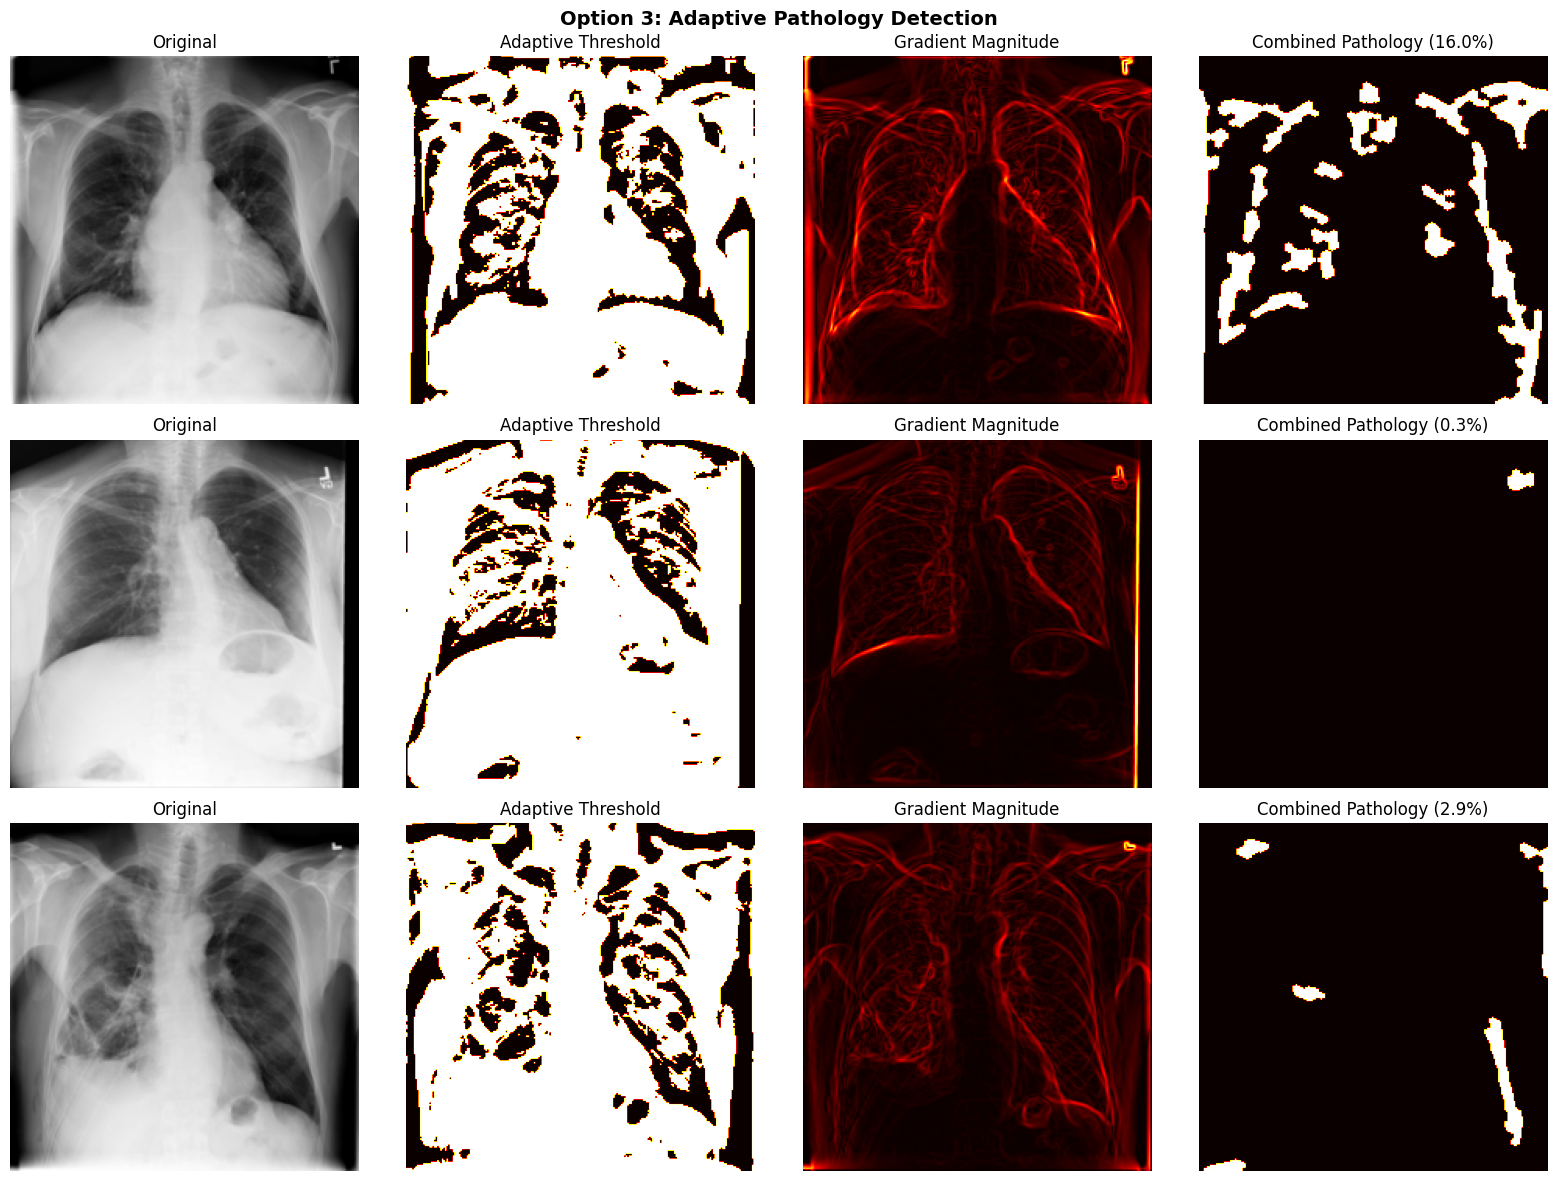

In [6]:
# ============================================
# 👁️ Step 5: Visualize Pathology Detection
# ============================================

sample_indices = [0, 100, 500]
fig, axes = plt.subplots(len(sample_indices), 4, figsize=(16, 4*len(sample_indices)))

for i, idx in enumerate(sample_indices):
    img_path = df.iloc[idx]['Image Path']
    img = Image.open(img_path).convert('L')
    img = img.resize((cfg.img_size, cfg.img_size), Image.LANCZOS)
    img_np = np.array(img, dtype=np.float32) / 255.0
    
    # Get pathology mask
    pathology = adaptive_pathology_segmentation(img_np, cfg.adaptive_block_size, 
                                                cfg.adaptive_C, cfg.gradient_threshold)
    
    # Adaptive thresholding alone
    img_uint8 = (img_np * 255).astype(np.uint8)
    adaptive = cv2.adaptiveThreshold(img_uint8, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, cfg.adaptive_block_size, cfg.adaptive_C)
    
    # Gradient magnitude
    sobelx = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)
    gradient_mag = np.sqrt(sobelx**2 + sobely**2)
    gradient_mag = gradient_mag / (gradient_mag.max() + 1e-8)
    
    # Plot
    axes[i, 0].imshow(img_np, cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(adaptive, cmap='hot')
    axes[i, 1].set_title('Adaptive Threshold')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(gradient_mag, cmap='hot')
    axes[i, 2].set_title('Gradient Magnitude')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(pathology, cmap='hot')
    axes[i, 3].set_title(f'Combined Pathology ({pathology.mean():.1%})')
    axes[i, 3].axis('off')

plt.suptitle('Option 3: Adaptive Pathology Detection', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('option3_pathology_detection.png', dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# ============================================
# 🔄 Step 6: Augmentation & Datasets
# ============================================

class ChestXrayAugment:
    def __init__(self, img_size=224):
        self.img_size = img_size
    
    def __call__(self, img):
        if isinstance(img, np.ndarray):
            x = torch.tensor(img, dtype=torch.float32)
        else:
            x = img.clone()
        
        if random.random() < 0.5:
            x = torch.flip(x, dims=[2])
        if random.random() < 0.7:
            angle = random.uniform(-15, 15)
            x = transforms.functional.rotate(x, angle)
        if random.random() < 0.8:
            factor = 1 + random.uniform(-0.2, 0.2)
            x = transforms.functional.adjust_brightness(x, factor)
        if random.random() < 0.8:
            factor = 1 + random.uniform(-0.2, 0.2)
            x = transforms.functional.adjust_contrast(x, factor)
        if random.random() < 0.5:
            noise = torch.randn_like(x) * 0.05
            x = torch.clamp(x + noise, 0, 1)
        return x

augment = ChestXrayAugment(cfg.img_size)


class PathologyAwareDataset(Dataset):
    def __init__(self, df, transform=None, img_size=224):
        self.df = df.copy().reset_index(drop=True)
        self.transform = transform
        self.img_size = img_size
        
        sample_paths = self.df['Image Path'].sample(min(200, len(self.df)), random_state=42).values
        missing = [p for p in sample_paths if not os.path.exists(p)]
        if missing:
            raise FileNotFoundError(f"❌ Missing {len(missing)} images!")
        
        print(f"📦 PathologyAwareDataset: {len(self.df)} samples")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['Image Path']
        
        img = Image.open(img_path).convert('L')
        img = img.resize((self.img_size, self.img_size), Image.LANCZOS)
        img = np.array(img, dtype=np.float32) / 255.0
        img = np.expand_dims(img, 0)
        
        pathology_mask = adaptive_pathology_segmentation(img, cfg.adaptive_block_size, 
                                                         cfg.adaptive_C, cfg.gradient_threshold)
        pathology_mask = np.expand_dims(pathology_mask, 0)
        
        if self.transform:
            view1 = self.transform(img)
            view2 = self.transform(img)
        else:
            view1 = torch.tensor(img, dtype=torch.float32)
            view2 = torch.tensor(img, dtype=torch.float32)
        
        mask = torch.tensor(pathology_mask, dtype=torch.float32)
        
        return view1, view2, mask


class ClassificationDataset(Dataset):
    """Classification dataset WITH augmentation support for fine-tuning"""
    def __init__(self, df, disease_categories, img_size=224, is_training=False):
        self.df = df.copy().reset_index(drop=True)
        self.disease_categories = disease_categories
        self.img_size = img_size
        self.is_training = is_training  # ✅ Augmentation during fine-tuning!
        print(f"📦 ClassificationDataset: {len(self.df)} samples (training={is_training})")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['Image Path']).convert('L')
        img = img.resize((self.img_size, self.img_size), Image.LANCZOS)
        img = np.array(img, dtype=np.float32) / 255.0
        
        # ✅ Apply augmentation during training (like DannyNet)
        if self.is_training:
            if np.random.random() > 0.5:
                img = np.fliplr(img).copy()
            img = img * (0.8 + 0.4 * np.random.random())
            mean = img.mean()
            img = (img - mean) * (0.8 + 0.4 * np.random.random()) + mean
            if np.random.random() > 0.5:
                angle = np.random.uniform(-10, 10)
                img = rotate(img, angle, reshape=False, mode='constant', cval=0)
            img = np.clip(img, 0, 1)
        
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        labels = torch.tensor([row[d] for d in self.disease_categories], dtype=torch.float32)
        return img, labels

print("✅ Dataset classes defined (with training augmentation support)")

✅ Dataset classes defined (with training augmentation support)


In [ ]:
class Classifier(nn.Module):
    def __init__(self, feat_dim=256, num_classes=14):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.net(x)


class MobileNetV2Encoder(nn.Module):
    """MobileNetV2 Encoder backbone for feature extraction"""
    
    def __init__(self, in_channels=1, feat_dim=256, pretrained=True):
        super().__init__()
        from torchvision import models
        
        # Load pretrained MobileNetV2 (expects 3 channels)
        mobilenet = models.mobilenet_v2(pretrained=pretrained)
        
        # Adapt for grayscale (1 channel) input
        original_conv = mobilenet.features[0][0]
        new_conv = nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1, bias=False)
        
        # Initialize with average of RGB weights if converting from pretrained
        if pretrained and in_channels == 1:
            new_conv.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)
        
        mobilenet.features[0][0] = new_conv
        
        # Extract feature extractor (everything before classifier)
        self.features = mobilenet.features
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # MobileNetV2 output is 1280 channels
        self.fc = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, feat_dim)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Initialize models with backbone selection
if cfg.encoder_backbone == 'mobilenet_v2':
    encoder = MobileNetV2Encoder(feat_dim=cfg.feat_dim, pretrained=True).to(cfg.device)
    print(f"✅ Using MobileNetV2 encoder backbone")
else:
    encoder = Encoder(feat_dim=cfg.feat_dim).to(cfg.device)
    print(f"✅ Using custom CNN encoder backbone")

proj_head = ProjectionHead(cfg.feat_dim, cfg.proj_dim).to(cfg.device)
decoder = Decoder(cfg.feat_dim, cfg.img_size).to(cfg.device)

total_params = sum(p.numel() for m in [encoder, proj_head, decoder] for p in m.parameters())
print(f"✅ Models initialized ({total_params:,} parameters)")


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
# ============================================
# 🔥 Step 8: Loss Functions
# ============================================

def nt_xent_loss(z1, z2, temperature=0.1):
    device = z1.device
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    batch_size = z1.shape[0]
    representations = torch.cat([z1, z2], dim=0)
    similarity = torch.matmul(representations, representations.T) / temperature
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=device)
    similarity = similarity.masked_fill(mask, -float('inf'))
    labels = torch.cat([torch.arange(batch_size) + batch_size,
                        torch.arange(batch_size)]).to(device)
    return F.cross_entropy(similarity, labels)


def pathology_aware_loss(proj_1, proj_2, pathology_mask_1, pathology_mask_2, 
                         temperature=0.1, pathology_weight=0.5):
    """
    🎯 KEY INNOVATION: Pathology-aware contrastive loss
    
    - Base NT-Xent loss
    - Emphasizes images with detected pathological regions
    - Higher weight for images with clear abnormalities
    """
    base_loss = nt_xent_loss(proj_1, proj_2, temperature)
    
    path_score_1 = pathology_mask_1.mean(dim=[1, 2, 3])
    path_score_2 = pathology_mask_2.mean(dim=[1, 2, 3])
    pathology_score = (path_score_1 + path_score_2) / 2
    
    batch_weights = 1.0 + pathology_weight * pathology_score.to(proj_1.device)
    avg_weight = batch_weights.mean()
    
    return base_loss * avg_weight


class FocalLoss(nn.Module):
    """
    ⭐ Focal Loss for handling class imbalance (from DannyNet SOTA)
    FL(p_t) = -alpha * (1 - p_t)^gamma * log(p_t)
    """
    def __init__(self, alpha=1.0, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

print("✅ Loss functions defined")
print("   🎯 pathology_aware_loss: Emphasizes abnormal regions")
print("   ⭐ FocalLoss: For class imbalance (α=1.0, γ=2.0)")

In [ ]:
# ============================================
# 📊 Step 9: Create Data Loaders (Patient-Level Split)
# ============================================

# ⚠️ CRITICAL: Patient-level splitting to prevent data leakage
print("="*60)
print("🔀 PATIENT-LEVEL SPLITTING")
print("="*60)

unique_patients = df['Patient ID'].unique()
print(f"Total unique patients: {len(unique_patients):,}")

# Split patients: 93% train, 5% val, 2% test
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.02, random_state=42
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.052, random_state=42
)

train_df = df[df['Patient ID'].isin(train_patients)].copy()
val_df = df[df['Patient ID'].isin(val_patients)].copy()
test_df = df[df['Patient ID'].isin(test_patients)].copy()

print(f"✓ Train: {len(train_df):,} images from {len(train_patients):,} patients")
print(f"✓ Val: {len(val_df):,} images from {len(val_patients):,} patients")
print(f"✓ Test: {len(test_df):,} images from {len(test_patients):,} patients")
print("="*60)

if cfg.use_subset:
    train_df = train_df.head(cfg.subset_size)
    val_df = val_df.head(cfg.subset_size // 4)
    test_df = test_df.head(cfg.subset_size // 8)
    print(f"⚡ Using subset: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test")

# Datasets - NOW WITH AUGMENTATION FOR TRAINING
train_pretrain_ds = PathologyAwareDataset(train_df, transform=augment, img_size=cfg.img_size)
train_class_ds = ClassificationDataset(train_df, DISEASE_CATEGORIES, cfg.img_size, is_training=True)  # ✅ Augmentation ON
val_class_ds = ClassificationDataset(val_df, DISEASE_CATEGORIES, cfg.img_size, is_training=False)
test_class_ds = ClassificationDataset(test_df, DISEASE_CATEGORIES, cfg.img_size, is_training=False)

# DataLoaders - FAST PIPELINE (like tf.data)
# 🚀 num_workers: Parallel data loading (like num_parallel_calls)
# 🚀 pin_memory: Faster CPU→GPU transfer  
# 🚀 prefetch_factor: Prefetch batches per worker (like prefetch)
# 🚀 persistent_workers: Keep workers alive between epochs
pretrain_loader = DataLoader(
    train_pretrain_ds, batch_size=cfg.batch_size, shuffle=True,
    num_workers=cfg.num_workers, pin_memory=True, drop_last=True,
    prefetch_factor=2, persistent_workers=True if cfg.num_workers > 0 else False
)
train_loader = DataLoader(
    train_class_ds, batch_size=cfg.batch_size, shuffle=True,
    num_workers=cfg.num_workers, pin_memory=True, drop_last=True,
    prefetch_factor=2, persistent_workers=True if cfg.num_workers > 0 else False
)
val_loader = DataLoader(
    val_class_ds, batch_size=cfg.batch_size, shuffle=False,
    num_workers=cfg.num_workers, pin_memory=True,
    prefetch_factor=2, persistent_workers=True if cfg.num_workers > 0 else False
)
test_loader = DataLoader(
    test_class_ds, batch_size=cfg.batch_size, shuffle=False,
    num_workers=cfg.num_workers, pin_memory=True,
    prefetch_factor=2, persistent_workers=True if cfg.num_workers > 0 else False
)

print(f"✅ DataLoaders ready - FAST PIPELINE (with training augmentation)")
print(f"   Train batches: {len(pretrain_loader)}")
print(f"   Test batches: {len(test_loader)}")

In [ ]:
# ============================================
# 🚀 Step 10: Pathology-Aware SSL Pretraining
# ============================================

# Clear GPU cache before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()

optimizer_ssl = torch.optim.Adam(
    list(encoder.parameters()) + list(proj_head.parameters()) + list(decoder.parameters()),
    lr=cfg.lr_pretrain, weight_decay=1e-4
)

ssl_history = {'loss': [], 'contrastive': [], 'reconstruction': []}
START_EPOCH = 1

if RESUME_SSL_PRETRAINING:
    ckpt_file = find_latest_checkpoint(f'{OPTION_NAME}_ssl') if SSL_CHECKPOINT_FILE == "latest" else SSL_CHECKPOINT_FILE
    if ckpt_file:
        checkpoint = load_checkpoint(ckpt_file)
        if checkpoint:
            encoder.load_state_dict(checkpoint['encoder'])
            proj_head.load_state_dict(checkpoint['proj_head'])
            decoder.load_state_dict(checkpoint['decoder'])
            if 'optimizer' in checkpoint: optimizer_ssl.load_state_dict(checkpoint['optimizer'])
            ssl_history = checkpoint.get('ssl_history', ssl_history)
            START_EPOCH = checkpoint['epoch'] + 1
            print(f"🔄 Resuming from epoch {START_EPOCH}")
    else:
        print("⚠️ No checkpoint found. Starting fresh.")

if START_EPOCH > cfg.pretrain_epochs:
    print(f"✅ SSL Pretraining already complete")
else:
    print(f"\n🚀 Starting Option 3: Pathology-Aware SSL Pretraining")
    print(f"   Epochs: {START_EPOCH} → {cfg.pretrain_epochs}")
    print("=" * 60)
    
    for epoch in range(START_EPOCH, cfg.pretrain_epochs + 1):
        encoder.train()
        proj_head.train()
        decoder.train()
        
        total_loss = total_cont = total_recon = 0
        
        loader = tqdm(pretrain_loader, desc=f"Epoch {epoch}/{cfg.pretrain_epochs}") if not IN_KAGGLE else pretrain_loader
        for view1, view2, pathology_mask in loader:
            view1 = view1.to(cfg.device)
            view2 = view2.to(cfg.device)
            pathology_mask = pathology_mask.to(cfg.device)
            
            optimizer_ssl.zero_grad()
            
            z1, z2 = encoder(view1), encoder(view2)
            p1, p2 = proj_head(z1), proj_head(z2)
            cont_loss = pathology_aware_loss(p1, p2, pathology_mask, pathology_mask, 
                                             cfg.temperature, cfg.pathology_weight)
            
            rec1, rec2 = decoder(z1), decoder(z2)
            recon_loss = (F.mse_loss(rec1, view1) + F.mse_loss(rec2, view2)) / 2
            
            loss = cont_loss + 0.5 * recon_loss
            loss.backward()
            optimizer_ssl.step()
            
            total_loss += loss.item()
            total_cont += cont_loss.item()
            total_recon += recon_loss.item()
            if not IN_KAGGLE:
                loader.set_postfix({'loss': f'{loss.item():.4f}'})
            
            # Free memory
            del z1, z2, p1, p2, rec1, rec2, loss, cont_loss, recon_loss
        
        # Clear cache at end of epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        n = len(pretrain_loader)
        ssl_history['loss'].append(total_loss / n)
        ssl_history['contrastive'].append(total_cont / n)
        ssl_history['reconstruction'].append(total_recon / n)
        
        print(f"Epoch {epoch}: Loss={total_loss/n:.4f}, Cont={total_cont/n:.4f}, Recon={total_recon/n:.4f}")
        
        save_checkpoint({
            'epoch': epoch, 'encoder': encoder.state_dict(),
            'proj_head': proj_head.state_dict(), 'decoder': decoder.state_dict(),
            'optimizer': optimizer_ssl.state_dict(), 'ssl_history': ssl_history,
        }, f'{OPTION_NAME}_ssl_latest.pth')
        save_checkpoint({
            'epoch': epoch, 'encoder': encoder.state_dict(),
            'proj_head': proj_head.state_dict(), 'decoder': decoder.state_dict(),
            'ssl_history': ssl_history,
        }, f'{OPTION_NAME}_ssl_epoch{epoch}.pth')
    
    print("\n✅ Pathology-Aware SSL Pretraining Complete!")

In [ ]:
# ============================================
# 📈 Step 11: Plot SSL Training Curves
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(ssl_history['loss'], 'b-', linewidth=2)
axes[0].set_title('Total Loss', fontsize=12)
axes[0].set_xlabel('Epoch')
axes[0].grid(True, alpha=0.3)

axes[1].plot(ssl_history['contrastive'], 'r-', linewidth=2)
axes[1].set_title('Pathology-Aware Contrastive Loss', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].grid(True, alpha=0.3)

axes[2].plot(ssl_history['reconstruction'], 'g-', linewidth=2)
axes[2].set_title('Reconstruction Loss', fontsize=12)
axes[2].set_xlabel('Epoch')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Option 3: Pathology-Aware SSL Training', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('option3_ssl_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================
# 💾 Step 12: Save Pretrained Model
# ============================================

torch.save({
    'encoder': encoder.state_dict(),
    'proj_head': proj_head.state_dict(),
    'decoder': decoder.state_dict(),
    'config': {'feat_dim': cfg.feat_dim, 'proj_dim': cfg.proj_dim}
}, 'option3_ssl_pretrained.pth')

print("💾 Pretrained model saved: option3_ssl_pretrained.pth")

In [ ]:
# ============================================
# 🎯 Step 13: Fine-tuning
# ============================================
# KEY IMPROVEMENTS (inspired by DannyNet SOTA):
# 1. UNFREEZE encoder with differential learning rate
# 2. Use Focal Loss instead of BCE
# 3. Use AdamW optimizer
# 4. More aggressive LR scheduler (factor=0.1, patience=2)
# ============================================

# ✅ UNFREEZE encoder for fine-tuning (CRITICAL for performance!)
for param in encoder.parameters():
    param.requires_grad = True  # UNFROZEN!
encoder.train()

classifier = Classifier(cfg.feat_dim, len(DISEASE_CATEGORIES)).to(cfg.device)

# ✅ Use Focal Loss
criterion = FocalLoss(alpha=1.0, gamma=2.0)

# ✅ Differential learning rates with AdamW
encoder_lr = cfg.lr_finetune / 10
classifier_lr = cfg.lr_finetune

optimizer_ft = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': encoder_lr},
    {'params': classifier.parameters(), 'lr': classifier_lr}
], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ft, mode='max', patience=2, factor=0.1, min_lr=1e-7
)

print("🔧 Fine-tuning Configuration:")
print(f"   ✅ Encoder: UNFROZEN with LR={encoder_lr:.2e}")
print(f"   ✅ Classifier LR: {classifier_lr:.2e}")
print(f"   ✅ Loss: FocalLoss (α=1.0, γ=2.0)")
print(f"   ✅ Optimizer: AdamW")

finetune_history = {'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_auc': []}
best_val_auc = 0
FINETUNE_START_EPOCH = 1

if RESUME_FINETUNING:
    ckpt_file = find_latest_checkpoint(f'{OPTION_NAME}_finetune') if FINETUNE_CHECKPOINT_FILE == "latest" else FINETUNE_CHECKPOINT_FILE
    if ckpt_file:
        ft_ckpt = load_checkpoint(ckpt_file)
        if ft_ckpt:
            classifier.load_state_dict(ft_ckpt['classifier'])
            if 'encoder' in ft_ckpt:
                encoder.load_state_dict(ft_ckpt['encoder'])
            if 'optimizer' in ft_ckpt:
                try:
                    optimizer_ft.load_state_dict(ft_ckpt['optimizer'])
                except:
                    print("⚠️ Optimizer state incompatible, starting fresh")
            finetune_history = ft_ckpt.get('finetune_history', finetune_history)
            best_val_auc = ft_ckpt.get('best_val_auc', 0)
            FINETUNE_START_EPOCH = ft_ckpt['epoch'] + 1
            print(f"🔄 Resuming fine-tuning from epoch {FINETUNE_START_EPOCH}")

if FINETUNE_START_EPOCH > cfg.finetune_epochs:
    print(f"✅ Fine-tuning already complete")
else:
    print(f"\n🎯 Starting Fine-tuning (ENCODER UNFROZEN)")
    print(f"   Epochs: {FINETUNE_START_EPOCH} → {cfg.finetune_epochs}")
    print("=" * 50)
    
    for epoch in range(FINETUNE_START_EPOCH, cfg.finetune_epochs + 1):
        encoder.train()  # Encoder is also training now!
        classifier.train()
        train_loss = 0
        train_preds, train_targets = [], []
        
        loader = tqdm(train_loader, desc=f"Train {epoch}/{cfg.finetune_epochs}") if not IN_KAGGLE else train_loader
        for images, targets in loader:
            images, targets = images.to(cfg.device), targets.to(cfg.device)
            optimizer_ft.zero_grad()
            
            # ✅ NO torch.no_grad() - encoder is being fine-tuned!
            features = encoder(images)
            logits = classifier(features)
            loss = criterion(logits, targets)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
            optimizer_ft.step()
            
            train_loss += loss.item()
            train_preds.append(torch.sigmoid(logits).detach().cpu())
            train_targets.append(targets.cpu())
        
        encoder.eval()
        classifier.eval()
        val_loss = 0
        val_preds, val_targets = [], []
        
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(cfg.device)
                features = encoder(images)
                logits = classifier(features)
                loss = criterion(logits, targets.to(cfg.device))
                val_loss += loss.item()
                val_preds.append(torch.sigmoid(logits).cpu())
                val_targets.append(targets.cpu())
        
        train_preds, train_targets = torch.cat(train_preds).numpy(), torch.cat(train_targets).numpy()
        val_preds, val_targets = torch.cat(val_preds).numpy(), torch.cat(val_targets).numpy()
        
        train_auc = np.mean([roc_auc_score(train_targets[:, i], train_preds[:, i]) 
                             for i in range(len(DISEASE_CATEGORIES)) if len(np.unique(train_targets[:, i])) > 1])
        val_auc = np.mean([roc_auc_score(val_targets[:, i], val_preds[:, i]) 
                           for i in range(len(DISEASE_CATEGORIES)) if len(np.unique(val_targets[:, i])) > 1])
        
        finetune_history['train_loss'].append(train_loss / len(train_loader))
        finetune_history['train_auc'].append(train_auc)
        finetune_history['val_loss'].append(val_loss / len(val_loader))
        finetune_history['val_auc'].append(val_auc)
        scheduler.step(val_auc)
        
        current_lr = optimizer_ft.param_groups[0]['lr']
        print(f"Epoch {epoch}: Train AUC={train_auc:.4f}, Val AUC={val_auc:.4f}, LR={current_lr:.2e}")
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            save_checkpoint({'encoder': encoder.state_dict(), 'classifier': classifier.state_dict(),
                            'val_auc': val_auc, 'epoch': epoch}, f'{OPTION_NAME}_best_model.pth')
            print(f"  ✅ Best model saved! Val AUC: {val_auc:.4f}")
        
        if epoch % 5 == 0 or epoch == cfg.finetune_epochs:
            save_checkpoint({'epoch': epoch, 'encoder': encoder.state_dict(),
                            'classifier': classifier.state_dict(),
                            'optimizer': optimizer_ft.state_dict(), 'finetune_history': finetune_history,
                            'best_val_auc': best_val_auc}, f'{OPTION_NAME}_finetune_latest.pth')
    
    print(f"\n🏆 Best Validation AUC: {best_val_auc:.4f}")

In [ ]:
# ============================================
# 📊 Step 14: Final Evaluation & Test Set
# ============================================

from sklearn.metrics import f1_score, precision_score, recall_score

best_model_path = os.path.join(CHECKPOINT_DIR, f'{OPTION_NAME}_best_model.pth')
checkpoint = torch.load(best_model_path, weights_only=False)
encoder.load_state_dict(checkpoint['encoder'])
classifier.load_state_dict(checkpoint['classifier'])

encoder.eval()
classifier.eval()

# Validation Set Evaluation
all_preds, all_targets = [], []
with torch.no_grad():
    loader = tqdm(val_loader, desc="Evaluating Val") if not IN_KAGGLE else val_loader
    for images, targets in loader:
        images = images.to(cfg.device)
        features = encoder(images)
        logits = classifier(features)
        all_preds.append(torch.sigmoid(logits).cpu())
        all_targets.append(targets)

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print("\n📊 Validation Set - Per-Disease AUC Scores:")
print("=" * 40)
val_auc_scores = []
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(all_targets[:, i])) > 1:
        auc = roc_auc_score(all_targets[:, i], all_preds[:, i])
        val_auc_scores.append((disease, auc))
        print(f"{disease:20s}: {auc:.4f}")

val_mean_auc = np.mean([a for _, a in val_auc_scores])
print(f"\n{'Val Mean AUC':20s}: {val_mean_auc:.4f}")

# ============================================
# 🎯 Find Optimal Per-Disease Thresholds
# ============================================
print("\n" + "="*60)
print("🎯 OPTIMAL THRESHOLD SEARCH (per-disease)")
print("="*60)

optimal_thresholds = {}
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(all_targets[:, i])) > 1:
        best_f1, best_thresh = 0, 0.5
        for thresh in np.arange(0.1, 0.9, 0.02):
            preds_binary = (all_preds[:, i] > thresh).astype(int)
            if preds_binary.sum() > 0 and (1 - preds_binary).sum() > 0:
                f1 = f1_score(all_targets[:, i], preds_binary, zero_division=0)
                if f1 > best_f1:
                    best_f1, best_thresh = f1, thresh
        optimal_thresholds[disease] = best_thresh
        print(f"{disease:20s}: optimal thresh = {best_thresh:.2f}, F1 = {best_f1:.4f}")

# ============================================
# 🧪 Test Set Evaluation (Held-Out)
# ============================================

print("\n" + "="*60)
print("🧪 TEST SET EVALUATION (Patient-Level Held-Out)")
print("="*60)

test_preds, test_targets = [], []
with torch.no_grad():
    loader = tqdm(test_loader, desc="Evaluating Test") if not IN_KAGGLE else test_loader
    for images, targets in loader:
        images = images.to(cfg.device)
        features = encoder(images)
        logits = classifier(features)
        test_preds.append(torch.sigmoid(logits).cpu())
        test_targets.append(targets)

test_preds = torch.cat(test_preds).numpy()
test_targets = torch.cat(test_targets).numpy()

print("\n📊 Test Set - Per-Disease AUC Scores:")
print("=" * 40)
test_auc_scores = []
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        auc = roc_auc_score(test_targets[:, i], test_preds[:, i])
        test_auc_scores.append((disease, auc))
        print(f"{disease:20s}: {auc:.4f}")

test_mean_auc = np.mean([a for _, a in test_auc_scores])
print(f"\n{'Test Mean AUC':20s}: {test_mean_auc:.4f}")

# Test with OPTIMAL thresholds
print("\n📊 Test Set - With Optimal Thresholds:")
print("=" * 60)
print(f"{'Disease':20s} {'AUC':>8s} {'Thresh':>8s} {'F1':>8s} {'Precision':>10s} {'Recall':>8s}")
print("-" * 60)

test_f1_scores = []
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        auc = roc_auc_score(test_targets[:, i], test_preds[:, i])
        thresh = optimal_thresholds.get(disease, 0.5)
        preds_binary = (test_preds[:, i] > thresh).astype(int)
        f1 = f1_score(test_targets[:, i], preds_binary, zero_division=0)
        prec = precision_score(test_targets[:, i], preds_binary, zero_division=0)
        rec = recall_score(test_targets[:, i], preds_binary, zero_division=0)
        test_f1_scores.append(f1)
        print(f"{disease:20s} {auc:8.4f} {thresh:8.2f} {f1:8.4f} {prec:10.4f} {rec:8.4f}")

print("-" * 60)
print(f"{'MEAN':20s} {test_mean_auc:8.4f} {'--':>8s} {np.mean(test_f1_scores):8.4f}")

# Plot
test_auc_scores.sort(key=lambda x: x[1], reverse=True)
diseases, aucs = zip(*test_auc_scores)

plt.figure(figsize=(12, 6))
colors = ['green' if a >= 0.7 else 'orange' if a >= 0.6 else 'red' for a in aucs]
plt.barh(diseases, aucs, color=colors, alpha=0.8)
plt.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Random')
plt.axvline(test_mean_auc, color='blue', linestyle='--', alpha=0.7, label=f'Test Mean: {test_mean_auc:.3f}')
plt.xlabel('AUC Score')
plt.title('Option 3: Test Set Per-Disease AUC Performance', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig('option3_test_auc_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("📝 OPTION 3: PATHOLOGY-AWARE SSL SUMMARY")
print("=" * 60)
print(f"Method: Adaptive Thresholding + Gradient-Based Pathology Detection")
print(f"Key: Emphasizes images with detected abnormal regions")
print(f"\nDataset: NIH Chest X-ray 14 (Patient-Level Split)")
print(f"  - Training: {len(train_df):,} images ({len(train_patients):,} patients)")
print(f"  - Validation: {len(val_df):,} images ({len(val_patients):,} patients)")
print(f"  - Test: {len(test_df):,} images ({len(test_patients):,} patients)")
print(f"\nResults:")
print(f"  📈 Validation Mean AUC: {val_mean_auc:.4f}")
print(f"  🧪 Test Mean AUC: {test_mean_auc:.4f}")
print("=" * 60)